<a href="https://colab.research.google.com/github/wafaahs/domain-name-generator/blob/main/domain_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 - Synthetic Dataset Creation

In [1]:
# 🔧 Core dependencies for generation, scoring, and analysis
# 📦 Installation (run this cell first if packages are missing)
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
# !pip install transformers scikit-learn
# !pip install pandas matplotlib seaborn tqdm
# !pip install sentence-transformers

# Core
!pip install torch transformers sentence-transformers tqdm

# Optional semantic similarity metrics
!pip install tensorflow tensorflow-hub  # for USE
!pip install gensim                     # for Doc2Vec
!pip install bert-score                  # for BERTScore
!pip install jellyfish                   # for Jaro-Winkler
!pip install pyemd                       # for Word Mover's Distance



  Using cached bert_score-0.3.13-py3-none-any.whl.metadata (15 kB)
Using cached bert_score-0.3.13-py3-none-any.whl (61 kB)
  Using cached jellyfish-1.2.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.6 kB)
Using cached jellyfish-1.2.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (356 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 666.6/666.6 kB 12.8 MB/s eta 0:00:00


## 1.1 Generate the Dataset

In [20]:
# Imports and Setup
import random
import json
import torch
from pathlib import Path
from transformers import BertTokenizer, BertModel, BartTokenizer, BartModel
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.notebook import tqdm
from sentence_transformers import SentenceTransformer

import jellyfish
import tensorflow_hub as hub
from gensim.models.doc2vec import Doc2Vec
import bert_score
import pandas as pd



In [22]:
# Supress Warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from transformers import logging
logging.set_verbosity_error()



In [5]:
# Configuration: TLDs, Categories, Keywords, Adjectives, Business Types

# === Domain extension groups ===
TLD_GROUPS = {
    "common": [".com", ".net", ".org"],
    "tech": [".ai", ".tech", ".dev"],
    "ecommerce": [".store", ".shop", ".co"],
    "creative": [".studio", ".design", ".media"],
    "health": [".health", ".care", ".clinic"],
    "legal": [".legal", ".law"],
    "education": [".academy", ".edu"],
    "food": [".kitchen", ".menu"],
    "coffee": [".cafe", ".coffee"]
}

# === Categories with adjectives, business types, keywords ===
DOMAIN_CATEGORIES = {
    "food": {
        "adjectives": ["organic", "local", "vegan", "healthy", "homemade"],
        "business_types": ["meal service", "snack bar", "vegan diner", "organic eatery"],
        "keywords": ["organic", "local", "meal", "plate", "vegan", "snack", "deli", "healthy", "prep", "bites",
                     "grill", "menu", "dish", "eat", "serve", "flavor", "kitchen", "taste", "market", "chef"],
        "extension_keys": ["common", "food"]
    },
    "coffee": {
        "adjectives": ["cozy", "artisan", "independent", "sustainable", "premium"],
        "business_types": ["coffee shop", "espresso bar", "cafe", "roastery"],
        "keywords": ["beans", "brew", "cafe", "grind", "latte", "espresso", "blend", "java", "mug", "steam",
                     "barista", "pour", "aroma", "cup", "beanery", "drip", "grounds", "sips", "filter", "darkroast"],
        "extension_keys": ["common", "coffee"]
    },
    "tech": {
        "adjectives": ["innovative", "cloud-based", "scalable", "cutting-edge", "intelligent"],
        "business_types": ["AI SaaS startup", "blockchain platform", "mobile app developer"],
        "keywords": ["cloud", "bot", "data", "ai", "stack", "code", "dev", "logic", "compute", "neural",
                     "node", "cyber", "script", "deploy", "stream", "tensor", "model", "byte", "core", "matrix"],
        "extension_keys": ["common", "tech"]
    },
    "health": {
        "adjectives": ["holistic", "mindful", "therapeutic", "gentle", "wellness-focused"],
        "business_types": ["yoga studio", "nutritionist", "wellness center"],
        "keywords": ["calm", "vital", "fit", "care", "wellness", "med", "yoga", "therapy", "balance", "relax",
                     "mind", "body", "clinic", "heal", "energy", "breathe", "flow", "zen", "pulse", "restore"],
        "extension_keys": ["common", "health"]
    },
    "legal": {
        "adjectives": ["trusted", "professional", "experienced", "reputable", "compliant"],
        "business_types": ["law firm", "legal consultancy", "compliance office"],
        "keywords": ["legal", "justice", "firm", "counsel", "law", "brief", "case", "court", "advocate", "barrister",
                     "defense", "claim", "compliance", "rights", "ruling", "precedent", "trial", "witness", "verdict", "legaltech"],
        "extension_keys": ["common", "legal"]
    },
    "education": {
        "adjectives": ["interactive", "accessible", "global", "self-paced", "innovative"],
        "business_types": ["online academy", "language school", "tutoring platform"],
        "keywords": ["learn", "teach", "edu", "academy", "school", "class", "study", "brain", "train", "instruct",
                     "mentor", "pupil", "professor", "course", "lesson", "homework", "quiz", "read", "skills", "curriculum"],
        "extension_keys": ["common", "education"]
    },
    "ecommerce": {
        "adjectives": ["sustainable", "ethical", "minimalist", "convenient", "affordable"],
        "business_types": ["online shop", "eco product store", "fashion boutique"],
        "keywords": ["shop", "cart", "store", "buy", "eco", "green", "market", "checkout", "sale", "goods",
                     "pack", "brand", "vendor", "retail", "product", "online", "fashion", "style", "deal", "order"],
        "extension_keys": ["common", "ecommerce"]
    }
}

LOCATIONS = ["New York", "Austin", "San Francisco", "Los Angeles", "Berlin", "Beirut", "Brussels", "Montreal", "Paris"]
SUB_LOCATIONS = ["downtown", "midtown", "uptown", "old town", "main street", "the suburbs of", "the business district of"]

# # === Related categories for wrong-keyword generation ===
# RELATED_CATEGORIES = {
#     "food": ["coffee", "ecommerce"],
#     "coffee": ["food", "ecommerce"],
#     "tech": ["education", "ecommerce"],
#     "education": ["tech", "legal"],
#     "health": ["legal", "education"],
#     "legal": ["health", "education"],
#     "ecommerce": ["tech", "food"]
# }

# # === Quality mode weights ===
# QUALITY_MODES_WEIGHTS = {
#     "clean": 0.6,
#     "with_noise": 0.1,
#     "mismatched_extensions": 0.1,
#     "mixed_category_keywords": 0.1,
#     "wrong_category_keywords_soft": 0.05,
#     "wrong_category_keywords_strict": 0.05
# }


In [6]:
# # Extension Resolver
# def resolve_extensions(keys):
#     extensions = set()
#     for key in keys:
#         extensions.update(TLD_GROUPS.get(key, []))
#     return list(extensions)


In [37]:
# Scoring Logic Functions

# Load models once
BERT_TOKENIZER = BertTokenizer.from_pretrained("bert-base-uncased")
BERT_MODEL = BertModel.from_pretrained("bert-base-uncased")
BART_TOKENIZER = BartTokenizer.from_pretrained("facebook/bart-base")
BART_MODEL = BartModel.from_pretrained("facebook/bart-base")
SBERT_MODEL = SentenceTransformer("all-MiniLM-L6-v2")
USE_MODEL = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

DOC2VEC_MODEL = None  # train and set later if desired


# def encode(text, model, tokenizer):
#     inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
#     with torch.no_grad():
#         outputs = model(**inputs)
#     return outputs.last_hidden_state.mean(dim=1).numpy()
# def encode(text, model, tokenizer=None):
#     if(model == "sbert"):
#         return SBERT_MODEL.encode([text])
#     else:
#         inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
#         with torch.no_grad():
#             outputs = model(**inputs)
#         return outputs.last_hidden_state.mean(dim=1).numpy()

# def compute_confidence(domain, business_desc, method="heuristic"):
#     bus_desc_lower = business_desc.lower()

#     if method == "heuristic":
#         # score = 0.7
#         # if keyword_combo.replace(" ", "") in domain:
#         #     score += 0.1
#         # if ".com" in domain:
#         #     score += 0.05
#         # if len(domain) > 20:
#         #     score -= 0.1
#         # if any(char.isdigit() or char == '-' for char in domain):
#         #     score -= 0.2
#         # return round(min(max(score, 0.0), 1.0), 2)
#         score = 0.9
#         if any(word in domain for word in bus_desc_lower.split()):
#             score += 0.3
#         if ".com" in domain:
#             score += 0.15
#         if len(domain) > 20:
#             score -= 0.1
#         if any(c.isdigit() or c == '-' for c in domain):
#             score -= 0.2
#         return round(min(max(score, 0.0), 1.0), 2)

#     elif method == "bert":
#         domain_vec = encode(domain.replace(".", " "), BERT_MODEL, BERT_TOKENIZER)
#         keyword_vec = encode(bus_desc_lower, BERT_MODEL, BERT_TOKENIZER)
#         return round(float(cosine_similarity(domain_vec, keyword_vec)[0][0]), 2)

#     elif method == "bart":
#         domain_vec = encode(domain.replace(".", " "), BART_MODEL, BART_TOKENIZER)
#         keyword_vec = encode(bus_desc_lower, BART_MODEL, BART_TOKENIZER)
#         return round(float(cosine_similarity(domain_vec, keyword_vec)[0][0]), 2)

#     elif method == "sbert":
#         d_vec = encode(domain.replace(".", " "), "sbert")
#         k_vec = encode(bus_desc_lower, "sbert")
#         return round(float(cosine_similarity(d_vec, k_vec)[0][0]), 2)

#     elif method == "ensemble":
#         h = compute_confidence(domain, bus_desc_lower, method="heuristic")
#         b = compute_confidence(domain, bus_desc_lower, method="bert")
#         ba = compute_confidence(domain, bus_desc_lower, method="bart")
#         s = compute_confidence(domain, bus_desc_lower, "sbert")
#         return round(0.5 * h + 0.2 * b + 0.15 * ba + 0.15 * s, 2)

#     else:
#         raise ValueError("Unknown confidence method")

def encode(text, model, tokenizer, max_length=128):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=max_length)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).numpy()

def encode_sbert(text):
    return SBERT_MODEL.encode([text])

def encode_use(text):
    return USE_MODEL([text]).numpy()

def encode_doc2vec(text):
    return DOC2VEC_MODEL.infer_vector(text.lower().split()).reshape(1, -1)

# def compute_all_scores(domain, description):
#     scores = {}
#     # Heuristic
#     scores["heuristic"] = 0.7 + 0.1 * any(w in domain for w in description.lower().split())

#     # BERT
#     try:
#         d_vec = encode(domain.replace(".", " "), BERT_MODEL, BERT_TOKENIZER)
#         k_vec = encode(description, BERT_MODEL, BERT_TOKENIZER)
#         scores["bert"] = float(cosine_similarity(d_vec, k_vec)[0][0])
#     except Exception:
#         pass

#     # BART
#     try:
#         d_vec = encode(domain.replace(".", " "), BART_MODEL, BART_TOKENIZER)
#         k_vec = encode(description, BART_MODEL, BART_TOKENIZER)
#         scores["bart"] = float(cosine_similarity(d_vec, k_vec)[0][0])
#     except Exception:
#         pass

#     # SBERT
#     try:
#         d_vec = encode_sbert(domain.replace(".", " "))
#         k_vec = encode_sbert(description)
#         scores["sbert"] = float(cosine_similarity([d_vec[0]], [k_vec[0]])[0][0])
#     except Exception:
#         pass

#     # USE
#     try:
#         d_vec = encode_use(domain.replace(".", " "))
#         k_vec = encode_use(description)
#         scores["use"] = float(cosine_similarity(d_vec, k_vec)[0][0])
#     except Exception:
#         pass

#     # Doc2Vec
#     if DOC2VEC_MODEL:
#         try:
#             d_vec = encode_doc2vec(domain.replace(".", " "))
#             k_vec = encode_doc2vec(description)
#             scores["doc2vec"] = float(cosine_similarity(d_vec, k_vec)[0][0])
#         except Exception:
#             pass

#     # Jaro-Winkler
#     try:
#         scores["jaro_winkler"] = jellyfish.jaro_winkler_similarity(domain, description)
#     except Exception:
#         pass

#     # BERTScore
#     try:
#         P, R, F1 = bert_score.score([domain], [description], lang="en", verbose=False)
#         scores["bertscore_f1"] = float(F1[0])
#     except Exception:
#         pass

#     # WMD (requires word2vec embeddings in gensim)
#     try:
#         from gensim.test.utils import common_texts
#         from gensim.models import Word2Vec
#         w2v = Word2Vec(common_texts, vector_size=100, min_count=1)
#         scores["wmd"] = w2v.wv.wmdistance(domain.split(), description.split())
#         # Convert distance to similarity
#         if scores["wmd"] != float("inf"):
#             scores["wmd"] = 1 / (1 + scores["wmd"])
#         else:
#             scores.pop("wmd")
#     except Exception:
#         pass

#     return {k: round(v, 4) for k, v in scores.items()}



def normalize_score(val, min_val=0.0, max_val=1.0):
    """Safely normalize to [0,1], clipping extremes."""
    if val is None or pd.isna(val):
        return None
    if min_val == max_val:
        return 0.0
    norm = (val - min_val) / (max_val - min_val)
    return float(max(0.0, min(1.0, norm)))

def compute_all_scores(domain, description, quality_mode):
    scores = {}

     # Apply quality-based bonus/penalty
    if quality_mode == "clean":
        score_h = 0.9
    elif quality_mode in {"with_noise", "mismatched_extensions", "mixed_category_keywords"}:
        score_h = 0.5
    else:
        # covers wrong_category_keywords_soft / strict or unknown
        score_h = 0.0

    # --- Heuristic ---
    # score_h = 0.9
    if any(word in domain for word in description.split()):
        score_h += 0.2
    if ".com" in domain:
        score_h += 0.15
    if len(domain) > 20:
        score_h -= 0.1
    if any(c.isdigit() or c == '-' for c in domain):
        score_h -= 0.2
    heuristic_val = round(min(max(score_h, 0.0), 1.0), 2)

    # heuristic_val = 0.7 + 0.1 * any(w in domain for w in description.lower().split())

    scores["heuristic"] = normalize_score(heuristic_val)

    # --- BERT ---
    try:
        d_vec = encode(domain.replace(".", " "), BERT_MODEL, BERT_TOKENIZER)
        k_vec = encode(description, BERT_MODEL, BERT_TOKENIZER)
        val = float(cosine_similarity(d_vec, k_vec)[0][0])
        scores["bert"] = normalize_score(val, -1, 1)
    except Exception:
        pass

    # --- BART ---
    try:
        d_vec = encode(domain.replace(".", " "), BART_MODEL, BART_TOKENIZER)
        k_vec = encode(description, BART_MODEL, BART_TOKENIZER)
        val = float(cosine_similarity(d_vec, k_vec)[0][0])
        scores["bart"] = normalize_score(val, -1, 1)
    except Exception:
        pass

    # --- SBERT ---
    try:
        d_vec = encode_sbert(domain.replace(".", " "))
        k_vec = encode_sbert(description)
        val = float(cosine_similarity([d_vec[0]], [k_vec[0]])[0][0])
        scores["sbert"] = normalize_score(val, -1, 1)
    except Exception:
        pass

    # --- USE ---
    try:
        d_vec = encode_use(domain.replace(".", " "))
        k_vec = encode_use(description)
        val = float(cosine_similarity(d_vec, k_vec)[0][0])
        scores["use"] = normalize_score(val, -1, 1)
    except Exception:
        pass

    # --- Doc2Vec ---
    if DOC2VEC_MODEL:
        try:
            d_vec = encode_doc2vec(domain.replace(".", " "))
            k_vec = encode_doc2vec(description)
            val = float(cosine_similarity(d_vec, k_vec)[0][0])
            scores["doc2vec"] = normalize_score(val, -1, 1)
        except Exception:
            pass

    # --- Jaro-Winkler ---
    try:
        val = jellyfish.jaro_winkler_similarity(domain, description)
        scores["jaro_winkler"] = normalize_score(val)
    except Exception:
        pass

    # --- BERTScore (F1) ---
    try:
        P, R, F1 = bert_score.score([domain], [description], lang="en", verbose=False)
        scores["bertscore_f1"] = normalize_score(float(F1[0]))
    except Exception:
        pass

    # --- WMD (distance → similarity) ---
    try:
        from gensim.test.utils import common_texts
        from gensim.models import Word2Vec
        w2v = Word2Vec(common_texts, vector_size=100, min_count=1)
        dist = w2v.wv.wmdistance(domain.split(), description.split())
        if dist != float("inf"):
            sim = 1 / (1 + dist)
            scores["wmd"] = normalize_score(sim)
    except Exception:
        pass

    return {k: round(v, 4) for k, v in scores.items() if v is not None}


In [8]:
# Domain Generator
# def generate_domains(keywords, extensions):
#     num_keywords = random.randint(1, 5)
#     selected = random.sample(keywords, num_keywords)
#     base = "".join(selected).lower()
#     return base, [f"{base}{random.choice(extensions)}"]

def generate_domains(category):
    def resolve_extensions(keys):
        extensions = set()
        for key in keys:
            extensions.update(TLD_GROUPS.get(key, []))
        return list(extensions)

    config = DOMAIN_CATEGORIES[category]
    keywords = config["keywords"]
    extensions = resolve_extensions(config["extension_keys"])

    QUALITY_MODES_WEIGHTS = {
        "clean": 0.6,
        "with_noise": 0.1,
        "mismatched_extensions": 0.1,
        "mixed_category_keywords": 0.1,
        "wrong_category_keywords_soft": 0.05,
        "wrong_category_keywords_strict": 0.05
    }
    mode = random.choices(list(QUALITY_MODES_WEIGHTS), weights=list(QUALITY_MODES_WEIGHTS.values()))[0]

    def clean():
        selected = random.sample(keywords, k=random.randint(1, 5))
        base = "".join(selected).lower()
        return [f"{base}{random.choice(extensions)}"]

    def with_noise():
        selected = random.sample(keywords, k=random.randint(1, 3))
        base = "".join(selected).lower() + random.choice(["-123", "99", "xyz", "-dev", "000"])
        return [f"{base}{random.choice(extensions)}"]

    def mismatched_extensions():
        selected = random.sample(keywords, k=random.randint(2, 4))
        base = "".join(selected).lower()
        wrong_keys = list(set(TLD_GROUPS.keys()) - set(config["extension_keys"]))
        wrong_exts = resolve_extensions(random.sample(wrong_keys, k=1))
        return [f"{base}{random.choice(wrong_exts)}"]

    def mixed_category_keywords():
        other = random.choice(list(set(DOMAIN_CATEGORIES) - {category}))
        foreign = DOMAIN_CATEGORIES[other]["keywords"]
        selected = random.sample(keywords, k=random.randint(1, 2)) + random.sample(foreign, k=random.randint(1, 2))
        base = "".join(selected).lower()
        return [f"{base}{random.choice(extensions)}"]

    def wrong_category_keywords(soft=True):
        RELATED_CATEGORIES = {
            "food": ["coffee", "ecommerce"],
            "coffee": ["food", "ecommerce"],
            "tech": ["education", "ecommerce"],
            "education": ["tech", "legal"],
            "health": ["legal", "education"],
            "legal": ["health", "education"],
            "ecommerce": ["tech", "food"]
        }
        if soft and category in RELATED_CATEGORIES:
            pool = RELATED_CATEGORIES[category]
        else:
            pool = list(set(DOMAIN_CATEGORIES) - {category})
        wrong_cat = random.choice(pool)
        wrong_keywords = DOMAIN_CATEGORIES[wrong_cat]["keywords"]
        selected = random.sample(wrong_keywords, k=random.randint(2, 4))
        base = "".join(selected).lower()
        return [f"{base}{random.choice(extensions)}"]

    if mode == "clean":
        return clean(), mode
    elif mode == "with_noise":
        return with_noise(), mode
    elif mode == "mismatched_extensions":
        return mismatched_extensions(), mode
    elif mode == "mixed_category_keywords":
        return mixed_category_keywords(), mode
    elif mode == "wrong_category_keywords_soft":
        return wrong_category_keywords(soft=True), mode
    else:
        return wrong_category_keywords(soft=False), mode

In [38]:
# Business Entry Generator
# def generate_business_entry(category, location, extensions, config, method="heuristic"):
#     adjective = random.choice(config["adjectives"])
#     business_type = random.choice(config["business_types"])
#     description = f"A {adjective} {business_type} based in {location}"
#     base, domains = generate_domains(config["keywords"], extensions)


#     suggestions = [
#         {"domain": d, "confidence": compute_confidence(d, base.split(), method)}
#         for d in domains
#     ]
#     return {
#         "business_description": description,
#         "domain_suggestions": suggestions,
#         "category": category
#     }


# def generate_business_entry(category, location, extensions, config, method="ensemble"):
#     adjective = random.choice(config["adjectives"])
#     business_type = random.choice(config["business_types"])

#     article = "An" if starts_with_vowel(adjective) else "A"

#     description = f"{article} {adjective} {business_type} based in {location}"

#     base, domains = generate_domains(config["keywords"], extensions)


#     suggestions = []
#     for d in domains:
#         if method == "ensemble":
#             scores = {
#                 "heuristic": compute_confidence(d, base.split(), method="heuristic"),
#                 "bert": compute_confidence(d, base.split(), method="bert"),
#                 "bart": compute_confidence(d, base.split(), method="bart"),
#             }
#             confidence = round(
#                 0.5 * scores["heuristic"] +
#                 0.3 * scores["bert"] +
#                 0.2 * scores["bart"], 2
#             )
#         else:
#             score = compute_confidence(d, base.split(), method=method)
#             scores = {method: score}
#             confidence = score

#         suggestions.append({
#             "domain": d,
#             "confidence": confidence,
#             "scores": scores
#         })

#     return {
#         "business_description": description,
#         "domain_suggestions": suggestions,
#         "category": category
#     }

def generate_business_entry(method="ensemble"):
    def starts_with_vowel(word):
        return word[0].lower() in 'aeiou'
    category = random.choice(list(DOMAIN_CATEGORIES.keys()))
    config = DOMAIN_CATEGORIES[category]
    location = f"{random.choice(SUB_LOCATIONS)} {random.choice(LOCATIONS)}"
    # extensions = resolve_extensions(config["extension_keys"])
    adjective = random.choice(config["adjectives"])
    business_type = random.choice(config["business_types"])

    article = "An" if starts_with_vowel(adjective) else "A"

    description = f"{article} {adjective} {business_type} based in {location}"
    # base, domains = generate_domains(config["keywords"], extensions)

    domains, quality_mode = generate_domains(category)


    suggestions = []
    # for d in domains:
    #     if method == "ensemble":
    #         scores = {
    #             "heuristic": compute_confidence(d, description, method="heuristic"),
    #             "bert": compute_confidence(d, description, method="bert"),
    #             "bart": compute_confidence(d, description, method="bart"),
    #             "sbert": compute_confidence(d, description, method="bart"),
    #         }
    #         confidence = round(
    #             0.7 * scores["heuristic"] +
    #             0.1 * scores["bert"] +
    #             0.1 * scores["bart"] +
    #             0.1 * scores["sbert"], 2
    #         )
    #     else:
    #         score = compute_confidence(d, description, method=method)
    #         scores = {method: score}
    #         confidence = score

    #     suggestions.append({
    #         "domain": d,
    #         "confidence": confidence,
    #         "scores": scores
    #     })

    suggestions = []
    for d in domains:
      all_scores = compute_all_scores(d, description, quality_mode)
      suggestions.append({
          "domain": d,
          "confidence": None,  # no fixed confidence now
          "scores": all_scores
      })

    return {
        "business_description": description,
        "domain_suggestions": suggestions,
        "location": location,
        "category": category,
        "quality_mode": quality_mode
    }



In [15]:
# Dataset Generator
def create_dataset(num_entries=100, method="heuristic"):
    entries = []
    # for _ in range(num_entries):
    for _ in tqdm(range(num_entries), desc="Generating dataset"):
        # category = random.choice(list(DOMAIN_CATEGORIES.keys()))
        # config = DOMAIN_CATEGORIES[category]
        # location = f"{random.choice(SUB_LOCATIONS)} {random.choice(LOCATIONS)}"
        # extensions = resolve_extensions(config["extension_keys"])
        entry = generate_business_entry(method)
        entries.append(entry)
    return entries

# Save Function
def save_dataset(entries, filename="dataset.jsonl", output_format="jsonl"):
    path = Path(filename)
    with open(path, "w") as f:
        if output_format == "jsonl":
            for entry in entries:
                f.write(json.dumps(entry) + "\n")
        elif output_format == "json":
            json.dump(entries, f, indent=2)
        else:
            raise ValueError("Invalid output format")
    print(f"\n✅ Saved {len(entries)} entries to {path}")

# Append Function
def append_dataset(entries, filename="dataset.jsonl", output_format="jsonl", mode="a"):
    path = Path(filename)
    with open(path, mode) as f:
        if output_format == "jsonl":
            for entry in entries:
                f.write(json.dumps(entry) + "\n")
        elif output_format == "json":
            raise NotImplementedError("Appending to .json not supported.")
        else:
            raise ValueError("Invalid output format: use 'jsonl'")
    print(f"✅ Appended {len(entries)} entries to {path}")



In [16]:
# === 🚀 Unified generation function ===
def run_generation(
    dataset_size: int,
    output_path: str,
    confidence_method: str = "ensemble",
    mode: str = "append",
    batch_size: int = None,
    num_batches: int = None
):
    assert dataset_size > 0, "DATASET_SIZE must be > 0"

    if batch_size and num_batches:
        assert batch_size * num_batches == dataset_size, (
            f"Inconsistent: {batch_size} × {num_batches} ≠ {dataset_size}"
        )
    elif batch_size:
        num_batches = dataset_size // batch_size
        assert batch_size * num_batches == dataset_size, (
            f"DATASET_SIZE must be divisible by BATCH_SIZE"
        )
    elif num_batches:
        batch_size = dataset_size // num_batches
        assert batch_size * num_batches == dataset_size, (
            f"DATASET_SIZE must be divisible by NUM_BATCHES"
        )
    else:
        raise ValueError("You must define at least BATCH_SIZE or NUM_BATCHES")

    print(f"📦 Generating {dataset_size} entries in {num_batches} batches of {batch_size} using '{confidence_method}'...")

    for batch_num in tqdm(range(num_batches), desc="📊 Batches"):
        entries = create_dataset(num_entries=batch_size, method=confidence_method)

        if batch_num == 0 and mode == "save":
            save_dataset(entries, filename=output_path)
        else:
            append_dataset(entries, filename=output_path)

    print(f"✅ Completed generation: {dataset_size} entries → {output_path}")


In [ ]:
# Modify the values in this cell then run it to generate the dataset of your desired size.

OUTPUT_PATH = "synthetic_domain_dataset_v3.jsonl"
DATASET_SIZE = 10000
BATCH_SIZE = 100     # Set this OR NUM_BATCHES (not both unless they match DATASET_SIZE)
NUM_BATCHES = None  # ← Use None if you're setting BATCH_SIZE
MODE = "append"     # "save" or "append"
CONFIDENCE_METHOD = "ensemble"  # "heuristic", "bert", "bart", or "ensemble"

run_generation(
    dataset_size=DATASET_SIZE,
    output_path=OUTPUT_PATH,
    # confidence_method=CONFIDENCE_METHOD,
    mode=MODE,
    batch_size=BATCH_SIZE,
    num_batches=NUM_BATCHES
)


📦 Generating 10000 entries in 100 batches of 100 using 'ensemble'...


📊 Batches:   0%|          | 0/100 [00:00<?, ?it/s]

Generating dataset:   0%|          | 0/100 [00:00<?, ?it/s]

✅ Appended 100 entries to synthetic_domain_dataset_v3.jsonl


Generating dataset:   0%|          | 0/100 [00:00<?, ?it/s]

✅ Appended 100 entries to synthetic_domain_dataset_v3.jsonl


Generating dataset:   0%|          | 0/100 [00:00<?, ?it/s]

✅ Appended 100 entries to synthetic_domain_dataset_v3.jsonl


Generating dataset:   0%|          | 0/100 [00:00<?, ?it/s]

✅ Appended 100 entries to synthetic_domain_dataset_v3.jsonl


Generating dataset:   0%|          | 0/100 [00:00<?, ?it/s]

✅ Appended 100 entries to synthetic_domain_dataset_v3.jsonl


Generating dataset:   0%|          | 0/100 [00:00<?, ?it/s]

✅ Appended 100 entries to synthetic_domain_dataset_v3.jsonl


Generating dataset:   0%|          | 0/100 [00:00<?, ?it/s]

✅ Appended 100 entries to synthetic_domain_dataset_v3.jsonl


Generating dataset:   0%|          | 0/100 [00:00<?, ?it/s]

✅ Appended 100 entries to synthetic_domain_dataset_v3.jsonl


Generating dataset:   0%|          | 0/100 [00:00<?, ?it/s]

✅ Appended 100 entries to synthetic_domain_dataset_v3.jsonl


Generating dataset:   0%|          | 0/100 [00:00<?, ?it/s]

✅ Appended 100 entries to synthetic_domain_dataset_v3.jsonl


Generating dataset:   0%|          | 0/100 [00:00<?, ?it/s]

## 1.2 Analyse the Dataset

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import numpy as np
import re


In [42]:
# # Load and Flatten Dataset
def load_jsonl(filepath):
    data = []
    with open(filepath, "r") as f:
        for line in f:
            data.append(json.loads(line))
    return data

# def flatten_dataset(json_data):
#     rows = []
#     for entry in json_data:
#         desc = entry["business_description"]
#         cat = entry["category"]
#         for sug in entry["domain_suggestions"]:
#             row = {
#                 "domain": sug["domain"],
#                 "confidence": sug["confidence"],
#                 "category": cat,
#                 "description": desc,
#             }
#             for method, score in sug.get("scores", {}).items():
#                 row[f"score_{method}"] = score
#             rows.append(row)
#     return pd.DataFrame(rows)

# # 👇 Load and flatten
# raw_data = load_jsonl("synthetic_domain_dataset_v2.jsonl")
# df = flatten_dataset(raw_data)
# print(f"✅ Loaded {len(df)} domain entries")
# df.head()
def compute_confidence_from_scores(row, weights):
    """
    Compute a weighted average confidence from score_* columns.

    Parameters:
        row (pd.Series): The row of the DataFrame
        weights (dict): e.g. {"heuristic": 0.3, "bert": 0.2, "bart": 0.2, "sbert": 0.3}

    Returns:
        float: Weighted confidence score or NaN if no scores found
    """
    total_weight = 0
    weighted_sum = 0
    for metric, w in weights.items():
        col = f"score_{metric}"
        if col in row and pd.notna(row[col]):
            weighted_sum += row[col] * w
            total_weight += w
    return weighted_sum / total_weight if total_weight > 0 else np.nan



# WEIGHTS = {
#     "heuristic": 0.25,
#     "bert": 0.1,
#     "bart": 0.1,
#     "sbert": 0.2,
#     "use": 0.1,
#     "doc2vec": 0.1,
#     "bertscore_f1": 0.15
# }
WEIGHTS = {
    "heuristic": 0.4,
    "bert": 0.1,
    "bart": 0.1,
    "sbert": 0.1,
    "use": 0.1,
    "doc2vec": 0.1,
    "bertscore_f1": 0.1
}

def flatten_dataset(json_data):
    rows = []
    for entry in json_data:
        desc = entry.get("business_description", "")
        cat = entry.get("category", None)
        qmode = entry.get("quality_mode", None)

        for sug in entry.get("domain_suggestions", []):
            row = {
                "domain": sug.get("domain", ""),
                "confidence": sug.get("confidence", None),  # may be None (we recompute later)
                "category": cat,
                "quality_mode": qmode,
                "description": desc,
            }
            # Flatten scores dict into columns: score_<method>
            for method, score in (sug.get("scores") or {}).items():
                row[f"score_{method}"] = score
            rows.append(row)

    df = pd.DataFrame(rows)
    df["confidence"] = df.apply(lambda row: compute_confidence_from_scores(row, WEIGHTS), axis=1)

    # Ensure numeric dtypes for score_* and confidence
    score_cols = [c for c in df.columns if c.startswith("score_")]
    for c in score_cols + (["confidence"] if "confidence" in df.columns else []):
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # Optional: if confidence is missing, backfill with heuristic (keeps old charts working)
    if "confidence" in df.columns and "score_heuristic" in df.columns:
        df["confidence"] = df["confidence"].fillna(df["score_heuristic"])


    # Convenience features
    df["domain_length"] = df["domain"].str.len()
    df["tld"] = df["domain"].str.extract(r'(\.[A-Za-z0-9-]+)$')

    return df

# 👇 Load and flatten
PATH = "synthetic_domain_dataset_v3.jsonl"
raw_data = load_jsonl(PATH)
df = flatten_dataset(raw_data)
print(f"✅ Loaded {len(df)} domain entries from {PATH}")
display(df.head())

df.describe()

✅ Loaded 100 domain entries from synthetic_domain_dataset_v3.jsonl


,domain,confidence,category,quality_mode,description,score_heuristic,score_bert,score_bart,score_sbert,score_use,score_jaro_winkler,score_bertscore_f1,domain_length,tld
0,course.org,0.765033,education,clean,A self-paced language school based in the subu...,0.9,0.7192,0.6510,0.5755,0.4725,0.4634,0.8671,10,.org
1,modelneural.ai,0.788956,tech,clean,An intelligent AI SaaS startup based in old to...,0.9,0.7875,0.6385,0.6915,0.5868,0.4966,0.7963,14,.ai
2,matrixscriptdeploy99.ai,0.449956,tech,with_noise,A cloud-based mobile app developer based in th...,0.2,0.7471,0.6488,0.4974,0.5230,0.4886,0.8333,23,.ai
3,cafemugcuplatte.org,0.782633,coffee,clean,An independent roastery based in downtown Brus...,0.9,0.7758,0.6883,0.6763,0.4868,0.4031,0.8165,19,.org
4,blendbrew.store,0.621967,coffee,mismatched_extensions,An artisan espresso bar based in the suburbs o...,0.5,0.7694,0.7132,0.7086,0.5651,0.5352,0.8414,15,.store


,confidence,score_heuristic,score_bert,score_bart,score_sbert,score_use,score_jaro_winkler,score_bertscore_f1,domain_length
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.713317,0.743500,0.773541,0.678239,0.632900,0.530757,0.499545,0.830415,20.510000
std,0.130817,0.286273,0.030784,0.032116,0.069142,0.048763,0.055739,0.016591,7.422999
min,0.361389,0.000000,0.690100,0.585900,0.497400,0.425800,0.339500,0.788900,8.000000
25%,0.621331,0.500000,0.755325,0.659275,0.576400,0.497600,0.462000,0.822600,14.000000
50%,0.773233,0.900000,0.773600,0.676300,0.632850,0.522700,0.502200,0.828100,20.000000
75%,0.811914,1.000000,0.798625,0.701700,0.675850,0.560500,0.549025,0.841025,26.000000
max,0.863678,1.000000,0.846200,0.740700,0.831000,0.659200,0.615000,0.872500,36.000000


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


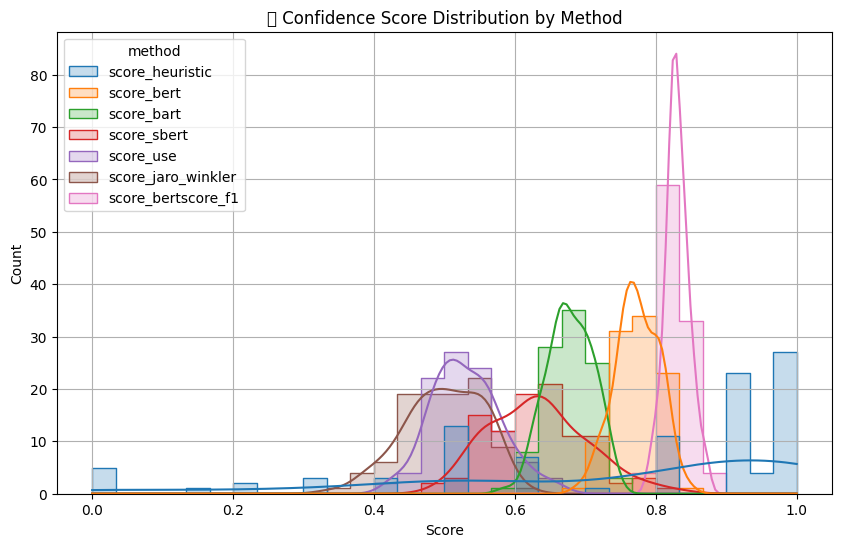

In [43]:
# Confidence Score Distribution
plt.figure(figsize=(10, 6))
score_cols = [col for col in df.columns if col.startswith("score_")]
df_long = df.melt(id_vars=["domain"], value_vars=score_cols, var_name="method", value_name="score")

sns.histplot(data=df_long, x="score", hue="method", bins=30, kde=True, element="step")
plt.title("🔍 Confidence Score Distribution by Method")
plt.xlabel("Score")
plt.ylabel("Count")
plt.grid(True)
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


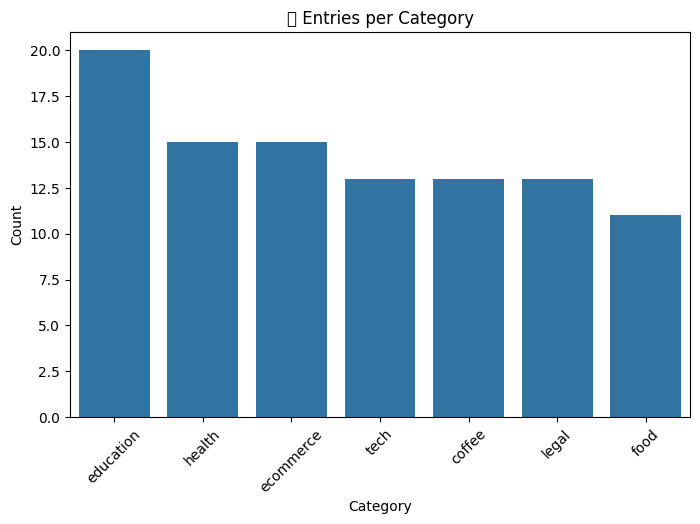

In [44]:
# Category Distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="category", order=df["category"].value_counts().index)
plt.xticks(rotation=45)
plt.title("📊 Entries per Category")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128289 (\N{INPUT SYMBOL FOR LATIN SMALL LETTERS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


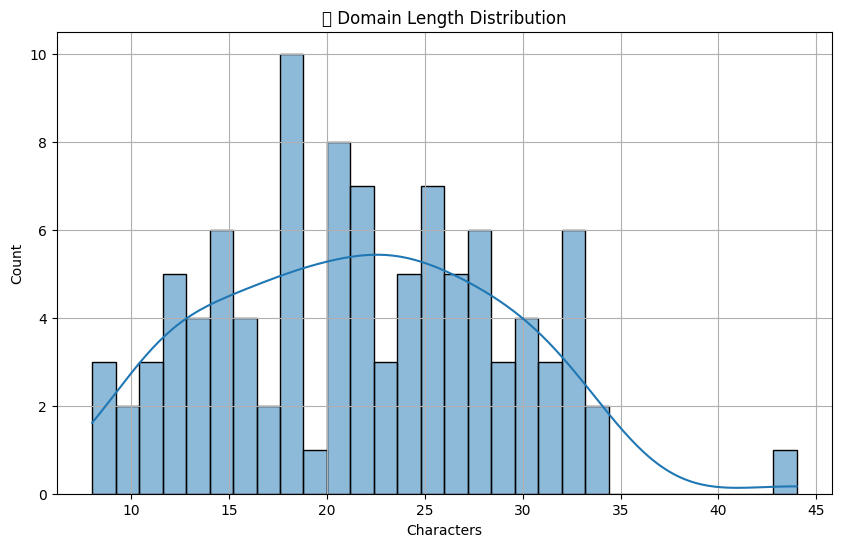

In [130]:
# Domain Length Distribution
df["domain_length"] = df["domain"].str.len()

plt.figure(figsize=(10, 6))
sns.histplot(df["domain_length"], bins=30, kde=True)
plt.title("🔡 Domain Length Distribution")
plt.xlabel("Characters")
plt.ylabel("Count")
plt.grid(True)
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


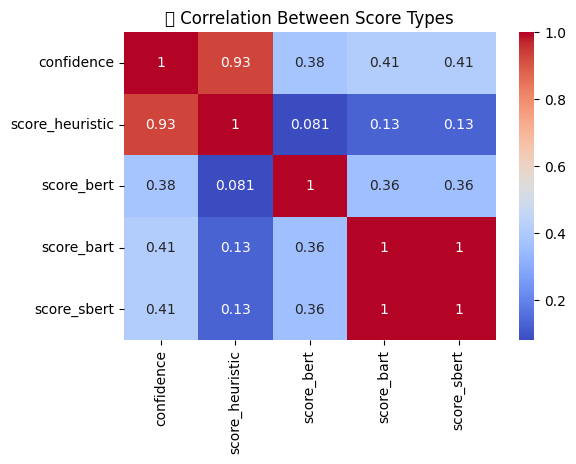

In [131]:
# Correlation Between Score Types
plt.figure(figsize=(6, 4))
sns.heatmap(df[[c for c in df.columns if c.startswith("score_") or c == "confidence"]].corr(), annot=True, cmap="coolwarm")
plt.title("🔁 Correlation Between Score Types")
plt.show()


In [45]:
# Outlier Examples
# 🔍 Show extreme cases
low_conf = df[df["confidence"] < 0.75].sort_values("confidence")
high_conf = df[df["confidence"] > 0.75].sort_values("confidence", ascending=False)

print("🧊 Low-confidence examples:")
display(low_conf.head())

print("🔥 High-confidence examples:")
display(high_conf.head())


🧊 Low-confidence examples:


,domain,confidence,category,quality_mode,description,score_heuristic,score_bert,score_bart,score_sbert,score_use,score_jaro_winkler,score_bertscore_f1,domain_length,tld
90,corestream.org,0.361389,food,wrong_category_keywords_strict,A healthy vegan diner based in midtown Austin,0.0,0.7271,0.6666,0.5491,0.4821,0.4090,0.8276,14,.org
30,computeaicyber.org,0.364989,education,wrong_category_keywords_soft,An interactive language school based in downto...,0.0,0.7634,0.6673,0.5444,0.4930,0.4925,0.8168,18,.org
98,dealfashion.dev,0.377389,tech,wrong_category_keywords_strict,A cloud-based mobile app developer based in th...,0.0,0.7181,0.6308,0.6030,0.6125,0.4867,0.8321,15,.dev
17,productbrandfashionstore.menu,0.380800,food,wrong_category_keywords_soft,A healthy vegan diner based in midtown Austin,0.0,0.8101,0.6726,0.5712,0.5441,0.5521,0.8292,29,.menu
24,witnesslegaltech.academy,0.388189,education,wrong_category_keywords_soft,An interactive tutoring platform based in midt...,0.0,0.8072,0.6894,0.6326,0.5411,0.4944,0.8234,24,.academy


🔥 High-confidence examples:


,domain,confidence,category,quality_mode,description,score_heuristic,score_bert,score_bart,score_sbert,score_use,score_jaro_winkler,score_bertscore_f1,domain_length,tld
42,steam.cafe,0.863678,coffee,clean,An artisan cafe based in old town New York,1.0,0.7562,0.7355,0.7858,0.6561,0.5802,0.8395,10,.cafe
87,dripcafebrewpourespresso.cafe,0.859089,coffee,clean,A premium espresso bar based in the suburbs of...,1.0,0.8221,0.6606,0.7987,0.6331,0.5806,0.8173,29,.cafe
28,marketproduct.store,0.857344,ecommerce,clean,An ethical eco product store based in the busi...,1.0,0.8025,0.7009,0.7316,0.6114,0.5134,0.8697,19,.store
19,sipsgrindfilterbaristagrounds.coffee,0.845033,coffee,clean,An independent espresso bar based in main stre...,1.0,0.7529,0.6738,0.7053,0.6592,0.5723,0.8141,36,.coffee
12,yogamindflowbodycare.care,0.845011,health,clean,A therapeutic wellness center based in uptown ...,1.0,0.8074,0.7246,0.6965,0.5496,0.4431,0.8270,25,.care


## 1.3 Save Reports

In [74]:
# !pip install fpdf
from fpdf import FPDF
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd


REPORT_DIR = "analytics_report"
PLOT_DIR = os.path.join(REPORT_DIR, "plots")
os.makedirs(PLOT_DIR, exist_ok=True)


In [75]:
def save_confidence_distribution(df):
    plt.figure(figsize=(8, 5))
    sns.histplot(df["confidence"], bins=30, kde=True)
    plt.title("Confidence Score Distribution")
    plt.xlabel("Confidence")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, "confidence_distribution.png"))
    plt.close()

def save_category_distribution(df):
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x="category", order=df["category"].value_counts().index)
    plt.title("Category Distribution")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, "category_distribution.png"))
    plt.close()

def save_confidence_vs_length(df):
    df["domain_length"] = df["domain"].apply(len)
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df, x="domain_length", y="confidence")
    plt.title("Confidence vs. Domain Length")
    plt.xlabel("Domain Length")
    plt.ylabel("Confidence")
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, "confidence_vs_length.png"))
    plt.close()


In [76]:
def save_category_stats(df):
    stats = df.groupby("category")["confidence"].agg(["count", "mean", "min", "max"]).reset_index()
    stats.columns = ["category", "count", "mean_conf", "min_conf", "max_conf"]
    stats.to_csv(os.path.join(REPORT_DIR, "stats.csv"), index=False)


In [77]:
def save_text_report(df):
    report_path = os.path.join(REPORT_DIR, "dataset_report.txt")
    with open(report_path, "w") as f:
        f.write("📄 Dataset Summary\n")
        f.write("="*40 + "\n")
        f.write(f"Total entries: {len(df)}\n")
        f.write(f"Confidence (min): {df['confidence'].min():.2f}\n")
        f.write(f"Confidence (max): {df['confidence'].max():.2f}\n")
        f.write(f"Confidence (mean): {df['confidence'].mean():.2f}\n\n")
        f.write("Entries by Category:\n")
        f.write(df["category"].value_counts().to_string())


In [78]:
def save_pdf_report(title="Domain Dataset Analytics"):
    pdf = FPDF()
    pdf.set_auto_page_break(auto=True, margin=15)
    pdf.add_page()
    pdf.set_font("Arial", size=16)
    pdf.cell(200, 10, title, ln=True, align="C")
    pdf.ln(10)

    for plot in sorted(glob(os.path.join(PLOT_DIR, "*.png"))):
        pdf.add_page()
        pdf.image(plot, w=180)

    pdf.output(os.path.join(REPORT_DIR, "report.pdf"))


In [79]:
def generate_full_report(df):
    print("📊 Generating analytics report...")

    save_confidence_distribution(df)
    save_category_distribution(df)
    save_confidence_vs_length(df)
    save_category_stats(df)
    save_text_report(df)
    save_pdf_report()

    print(f"✅ Analytics report saved to: `{REPORT_DIR}/`")


In [80]:
generate_full_report(df)

📊 Generating analytics report...
✅ Analytics report saved to: `analytics_report/`
